In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs, load_iris, load_wine, load_digits, fetch_openml, fetch_20newsgroups
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm

# Install KSil from GitHub:
!pip install git+https://github.com/semoglou/ksil.git

from ksil import KSil

In [3]:
class Silhouette:
    """
    Utility class for computing:
    - Micro-averaged Silhouette
      (S_micro: Mean of all individual silhouette scores for all samples)

    - Macro-averaged Silhouette
      (S_macro: Mean of all cluster-level silhouette scores)

    - (Convex) Combinations of the two scores (S_convex)
    """
    @staticmethod
    def Micro(X, labels):
        """
        Compute the micro-averaged silhouette score for all samples.
        Parameters:
        - X: array-like of shape (n_samples, n_features). Input data points.
        - labels: array-like of shape (n_samples,). Cluster labels for each sample.
        Returns:
        - float: The micro-averaged silhouette score.
        """
        return silhouette_score(X, labels)

    @staticmethod
    def Macro(X, labels):
        """
        Compute the macro-averaged silhouette score.
        Parameters:
        - X: array-like of shape (n_samples, n_features). Input data points.
        - labels: array-like of shape (n_samples,). Cluster labels for each sample.
        Returns:
        - float: The macro-averaged silhouette score.
        """
        silhouette_vals = silhouette_samples(X, labels)
        unique_labels = np.unique(labels)
        cluster_means = [
            np.mean(silhouette_vals[labels == lbl]) for lbl in unique_labels
        ]
        return np.mean(cluster_means) if cluster_means else 0

    @staticmethod
    def Convex(X, labels, alpha=0.5):
        """
        Compute a convex combination of micro-averaged and macro-averaged silhouette scores.
        Parameters:
        - X: array-like of shape (n_samples, n_features). Input data points.
        - labels: array-like of shape (n_samples,). Cluster labels for each sample.
        Returns:
        - float: The convex combination of the silhouette scores.
        """
        S_micro = Silhouette.Micro(X, labels)
        S_macro = Silhouette.Macro(X, labels)
        return alpha * S_micro + (1 - alpha) * S_macro

---

### Statistical Comparison of macro-averaged silhouette score performance between K-Sil and K-Means

**Datasets**

In [4]:
#  Synthetic dataset 1 (gaussian blobs with varied densities)
X_vb, _ = make_blobs(n_samples=500, centers=5, cluster_std=[1.0, 2.5, 0.5, 1.5, 3.0], random_state=42)

# Synthetic dataset 2 (high-dimensional blobs with regular std)
X_high_dim_1, y_high_dim_1 = make_blobs(
    n_samples=500,
    centers=5,
    n_features=12,
    cluster_std=1.0,
    random_state=42)

# Synthetic dataset 3 (high-dimensional blobs with high std)
X_high_dim_2, y_high_dim_2 = make_blobs(
    n_samples=500,
    centers=5,
    n_features=12,
    cluster_std=2.5,
    random_state=42)

# Synthetic dataset 4 (non-convex: rings and lines with noise)
def generate_ring_and_line_with_noise(n_points=1000, noise_ratio=0.5, ring_radius=5, ring_thickness=0.5, line_length=10):
    np.random.seed(42)
    n_noise = int(n_points * noise_ratio)
    n_cluster = n_points - n_noise
    n_per_cluster = n_cluster // 2
    angles = np.random.uniform(0, 2*np.pi, n_per_cluster)
    radii = np.random.normal(ring_radius, ring_thickness, n_per_cluster)
    x_ring = radii * np.cos(angles)
    y_ring = radii * np.sin(angles)
    x_line = np.random.normal(0, 0.3, n_per_cluster)
    y_line = np.random.uniform(-line_length/2, line_length/2, n_per_cluster)
    box_size = ring_radius * 3
    noise_x = np.random.uniform(-box_size, box_size, n_noise)
    noise_y = np.random.uniform(-box_size, box_size, n_noise)
    X = np.vstack([
        np.column_stack([x_ring, y_ring]),
        np.column_stack([x_line, y_line]),
        np.column_stack([noise_x, noise_y])
    ])
    return X
X_challenging = generate_ring_and_line_with_noise(
    n_points=1500,
    noise_ratio=0.5,
    ring_radius=5,
    ring_thickness=0.5,
    line_length=10)

# Iris dataset
data_iris = load_iris()
X_iris = data_iris.data
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Mice Protein dataset
data_mice = fetch_openml(name='MiceProtein', version=4, parser='auto')
X_mice = data_mice.data
imputer = SimpleImputer(strategy='mean')
X_mice_imputed = imputer.fit_transform(X_mice)
scaler = StandardScaler()
X_mice_scaled = scaler.fit_transform(X_mice_imputed)

# Glass dataset
data_glass = fetch_openml(name='glass', version=1, parser='auto')
X_glass = data_glass.data
scaler = StandardScaler()
X_glass_scaled = scaler.fit_transform(X_glass)

#  Wine dataset
data_wine = load_wine()
X_wine = data_wine.data
pca = PCA(n_components=0.95)
X_wine_reduced = pca.fit_transform(X_wine)

#  Digits dataset
data_digits = load_digits()
X_digits = data_digits.data
pca = PCA(n_components=0.95)
X_digits_reduced = pca.fit_transform(X_digits)

#  20 Newsgroups subset: baseball, hockey, autos, motorcycles (oberlapping categories)
categories_o = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.autos', 'rec.motorcycles']
newsgroups_o = fetch_20newsgroups(categories=categories_o, remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_data_txt_o = newsgroups_o.data
X_tfidf_o = vectorizer.fit_transform(X_data_txt_o)
X_tfidf_o = X_tfidf_o.toarray()
X_tfidf_o = PCA(0.90).fit_transform(X_tfidf_o)

- Average relative imrpovement in $S_{macro}$ (of K-Sil over K-Means) across $k \in \{1,\dots,10\}$

In [5]:
def evaluate_dataset_macro_silhouette(
    X,
    dataset_name='Dataset',
    k_values=range(2, 11),
    seeds=[42, 43, 44, 45, 46],
    method='power',
    approx=True, sample_s=-1
):
    results = []

    for k in k_values:
        for seed in seeds:
            # K-Means
            kmeans = KMeans(n_clusters=k, random_state=seed, n_init=1, init='random') # n_init=10, init='k-means++' or max_iter=100 to be the same as KSil
            kmeans_labels = kmeans.fit_predict(X)
            s_macro_kmeans = Silhouette.Macro(X, kmeans_labels)

            # K-Sil
            # silhouette_objective ='macro'
            ksil = KSil(n_clusters=k, init_method='random', silhouette_objective='macro', approximation=approx, sample_size=sample_s, weighting=method, random_state=seed, sensitivity='auto')
            ksil.fit(X)
            ksil_labels = ksil.labels_
            s_macro_ksil = Silhouette.Macro(X, ksil_labels)

            # Relative Improvement (%)
            # [(s_macro_ksil - s_macro_kmeans) / s_macro_kmeans] * 100
            if s_macro_kmeans == 0:
                rel_improvement = 0
            else:
                rel_improvement = (s_macro_ksil - s_macro_kmeans) / abs(s_macro_kmeans)
                rel_improvement *= 100

            results.append({
                'Dataset': dataset_name,
                'k': k,
                'Seed': seed,
                'S_macro_KMeans': s_macro_kmeans,
                'S_macro_KSil': s_macro_ksil,
                'Relative_Improvement (%)': rel_improvement
            })

    df_results = pd.DataFrame(results)
    return df_results

def analyze_dataset_s_macro(X, dataset_name='Dataset', method='power', approx=True, sample_s=-1):
    # Evaluate over k=2..10
    df_results = evaluate_dataset_macro_silhouette(
        X,
        dataset_name=dataset_name,
        k_values=range(2, 11),
        seeds=[42, 43, 44, 45, 46],
        method=method,
        approx=approx, sample_s=sample_s
    )

    # Differences for Wilcoxon = S_macro_KSil - S_macro_KMeans
    df_results['Difference'] = df_results['S_macro_KSil'] - df_results['S_macro_KMeans']

    # Array of differences for Wilcoxon test
    differences = df_results['Difference'].values
    # Remove any zero differences
    differences = differences[differences != 0]

    # Skip if all differences are zero or no differences
    if len(differences) == 0:
        return {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': 0.0,
            'Wilcoxon p-value': 1.0,
            'Statistical Significance (5%)': 'N/A'
        }

    # Run Wilcoxon test
    stat, p = wilcoxon(differences, alternative='greater')

    # Mean relative improvement
    mean_rel_improvement = df_results['Relative_Improvement (%)'].mean()

    significance_level = 0.05
    if p < significance_level:
        significant = '+'
    else:
        significant = '-'

    return {
        'Dataset': dataset_name,
        'Mean Overall Relative Improvement (%)': f"{mean_rel_improvement:.2f}%",
        'Statistical Significance (5%)': significant,
        'Wilcoxon p-value': p
    }

# Datasets and K-Sil parameters
datasets_info = [
    (X_vb, "Synthetic 1", "power", False, -1),
    (X_high_dim_1, "Synthetic 2", "power", False, -1),
    (X_high_dim_2, "Synthetic 3", "power", False, -1),
    (X_challenging, "Synthetic 4", "exponential", False, 0.8),
    (X_iris_scaled, "Iris", "exponential", False, -1),
    (X_mice_scaled, "Mice Protein", "exponential", False, -1),
    (X_glass_scaled, "Glass", "exponential", False, -1),
    (X_wine_reduced, "Wine", "exponential", False, -1),
    (X_digits_reduced, "Digits", "power", False, -1),
    (X_tfidf_o, "20 Newsgroups Subset", "power", False, 0.6)
]

summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(datasets_info),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar at the top
    leave=True
)

for X_data, name, method, approx, sample_s in datasets_info:
    dataset_start_time = time.time()

    summary = analyze_dataset_s_macro(X_data, dataset_name=name, method=method, approx=approx, sample_s=sample_s)
    summary_list.append(summary)

    dataset_end_time = time.time()
    dataset_elapsed_time = dataset_end_time - dataset_start_time

    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list)
df_summary.set_index('Dataset', inplace=True)

end_time = time.time()
total_elapsed_time = end_time - start_time

print("\nSummary of Macro-Averaged Mean Relative Silhouette Improvements (K-Sil vs. K-Means) - Exponential Weighting Scheme:")
display(df_summary)

if total_elapsed_time >= 60:
    total_elapsed_time /= 60
    print(f"\nTotal time taken: {total_elapsed_time:.2f} minutes.")
else:
    print(f"\nTotal time taken: {total_elapsed_time:.2f} seconds.")

Analyzing datasets: 100%|██████████ [Elapsed: 12:11 | Last: , 88.75s for 20 Newsgroups Subset]


Summary of Macro-Averaged Mean Relative Silhouette Improvements (K-Sil vs. K-Means) - Exponential Weighting Scheme:


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,7.73%,+,5.844413e-09
Synthetic 2,46.60%,+,9.094947e-13
Synthetic 3,30.43%,+,3.637979e-12
Synthetic 4,16.29%,+,5.684342e-14
Iris,13.35%,+,1.728040e-11
Mice Protein,42.41%,+,2.842171e-14
Glass,42.31%,+,5.684342e-14
Wine,4.03%,+,1.461103e-09
Digits,5.71%,+,6.750156e-11



Total time taken: 12.19 minutes.


- Average relative imrpovement in $S_{macro}$ at the ground-truth number of clusters $k_{GT}$

In [6]:
def evaluate_dataset_macro_silhouette_gt(
    X,
    k_gt,
    dataset_name='Dataset',
    seeds=[42, 43, 44, 45, 46],
    method='power',
    approx=True, sample_s=-1
):
    results = []

    for seed in seeds:
            # K-Means
            kmeans = KMeans(n_clusters=k_gt, random_state=seed, n_init=1, init='random') # n_init=10, init='k-means++' or max_iter=100 to be the same as KSil
            kmeans_labels = kmeans.fit_predict(X)
            s_macro_kmeans = Silhouette.Macro(X, kmeans_labels)

            # K-Sil
            # silhouette_objective ='macro'
            ksil = KSil(n_clusters=k_gt, init_method='random', silhouette_objective='macro', approximation=approx, sample_size=sample_s, weighting=method, random_state=seed, sensitivity='auto')
            ksil.fit(X)
            ksil_labels = ksil.labels_
            s_macro_ksil = Silhouette.Macro(X, ksil_labels)

            # Relative Improvement (%)
            # [(s_macro_ksil - s_macro_kmeans) / s_macro_kmeans] * 100
            if s_macro_kmeans == 0:
                rel_improvement = 0
            else:
                rel_improvement = (s_macro_ksil - s_macro_kmeans) / abs(s_macro_kmeans)
                rel_improvement *= 100

            results.append({
                'Dataset': dataset_name,
                'k': k_gt,
                'Seed': seed,
                'S_macro_KMeans': s_macro_kmeans,
                'S_macro_KSil': s_macro_ksil,
                'Relative_Improvement (%)': rel_improvement
            })

    df_results = pd.DataFrame(results)
    return df_results

def analyze_dataset_s_macro_gt(X, k_gt, dataset_name='Dataset', method='power', approx=True, sample_s=-1):
    # Evaluate over k=2..10
    df_results = evaluate_dataset_macro_silhouette_gt(
        X,
        dataset_name=dataset_name,
        k_gt=k_gt,
        seeds=np.arange(42, 63),
        method=method,
        approx=approx, sample_s=sample_s
    )

    # Differences for Wilcoxon = S_macro_KSil - S_macro_KMeans
    df_results['Difference'] = df_results['S_macro_KSil'] - df_results['S_macro_KMeans']

    # Array of differences for Wilcoxon test
    differences = df_results['Difference'].values
    # Remove any zero differences
    differences = differences[differences != 0]

    # Skip if all differences are zero or no differences
    if len(differences) == 0:
        return {
            'Dataset': dataset_name,
            'Mean Overall Relative Improvement (%)': 0.0,
            'Wilcoxon p-value': 1.0,
            'Statistical Significance (5%)': 'N/A'
        }

    # Run Wilcoxon test
    stat, p = wilcoxon(differences, alternative='greater')

    # Mean relative improvement
    mean_rel_improvement = df_results['Relative_Improvement (%)'].mean()

    significance_level = 0.05
    if p < significance_level:
        significant = '+'
    else:
        significant = '-'

    return {
        'Dataset': dataset_name,
        'Mean Overall Relative Improvement (%)': f"{mean_rel_improvement:.2f}%",
        'Statistical Significance (5%)': significant,
        'Wilcoxon p-value': p
    }

datasets_info = [
    (X_vb, 5, "Synthetic 1", "power", False, -1),
    (X_high_dim_1, 5, "Synthetic 2", "exponential", False, -1),
    (X_high_dim_2, 5, "Synthetic 3", "exponential", False, -1),
    (X_challenging, 4, "Synthetic 4", "exponential", False, 0.8),
    (X_iris_scaled, 3, "Iris", "exponential", False, -1),
    (X_mice_scaled, 8, "Mice Protein", "power", False, -1),
    (X_glass_scaled, 6, "Glass", "exponential", False, -1),
    (X_wine_reduced, 3, "Wine", "power", False, 0.8),
    (X_digits_reduced, 10,"Digits", "power", False, -1),
    (X_tfidf_o, 4, "20 Newsgroups Subset", "power", False, 0.6)
]

summary_list = []

start_time = time.time()

progress_bar = tqdm(
    total=len(datasets_info),
    desc="Analyzing datasets",
    bar_format="{l_bar}{bar} [Elapsed: {elapsed} | Last: {postfix}]",
    position=0,   # Progress bar stays at the top
    leave=True
)

for X_data, k_gt, name, method, approx, sample_s in datasets_info:
    dataset_start_time = time.time()

    summary = analyze_dataset_s_macro_gt(X_data, k_gt, dataset_name=name, method=method, approx=approx, sample_s=sample_s)
    summary_list.append(summary)

    dataset_end_time = time.time()
    dataset_elapsed_time = dataset_end_time - dataset_start_time

    progress_bar.set_postfix_str(f"{dataset_elapsed_time:.2f}s for {name}")
    progress_bar.update(1)

progress_bar.close()

df_summary = pd.DataFrame(summary_list)
df_summary.set_index('Dataset', inplace=True)

end_time = time.time()
total_elapsed_time = end_time - start_time

print("\nSummary of Macro-Averaged Mean Relative Silhouette Improvements (K-Sil vs. K-Means) - Power Weighting Scheme:")
display(df_summary)

if total_elapsed_time >= 60:
    total_elapsed_time /= 60
    print(f"\nTotal time taken: {total_elapsed_time:.2f} minutes.")
else:
    print(f"\nTotal time taken: {total_elapsed_time:.2f} seconds.")

Analyzing datasets: 100%|██████████ [Elapsed: 05:32 | Last: , 44.35s for 20 Newsgroups Subset]


Summary of Macro-Averaged Mean Relative Silhouette Improvements (K-Sil vs. K-Means) - Power Weighting Scheme:


,Mean Overall Relative Improvement (%),Statistical Significance (5%),Wilcoxon p-value
Dataset,,,
Synthetic 1,2.55%,+,4.768372e-07
Synthetic 2,42.56%,+,6.103516e-05
Synthetic 3,47.32%,+,1.831055e-04
Synthetic 4,36.22%,+,4.768372e-07
Iris,1.66%,+,1.907349e-06
Mice Protein,45.80%,+,4.768372e-07
Glass,50.25%,+,4.768372e-07
Wine,0.26%,-,8.255949e-01
Digits,9.02%,+,9.536743e-07



Total time taken: 5.54 minutes.


---

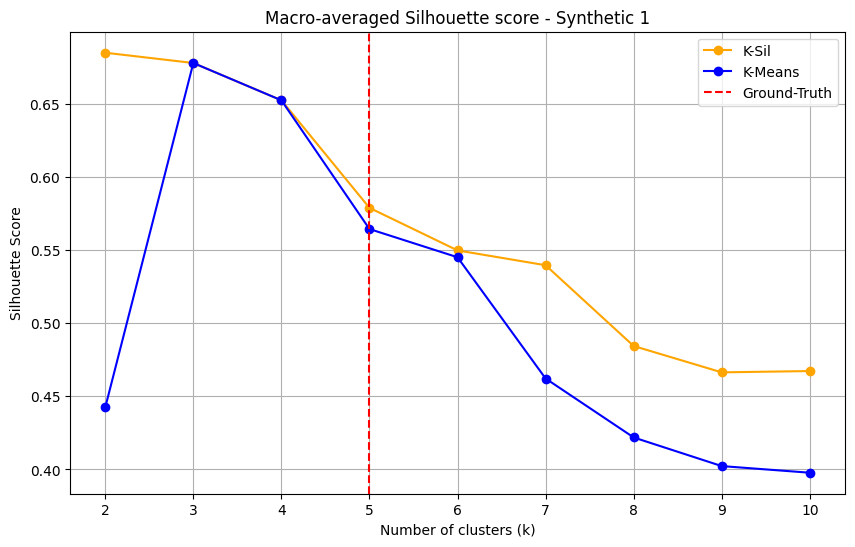

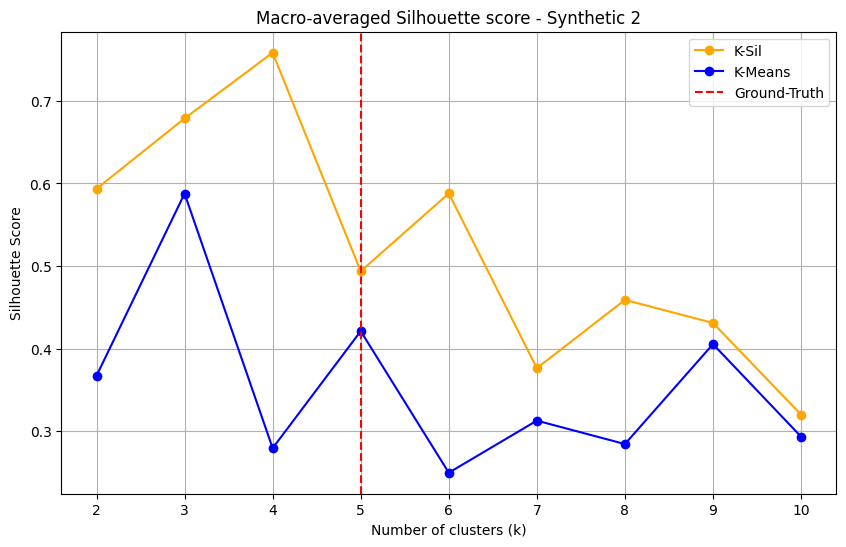

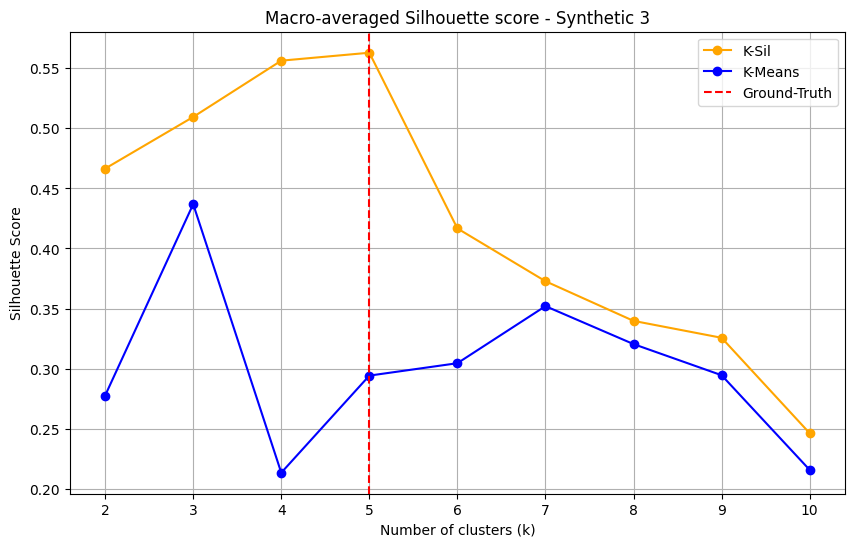

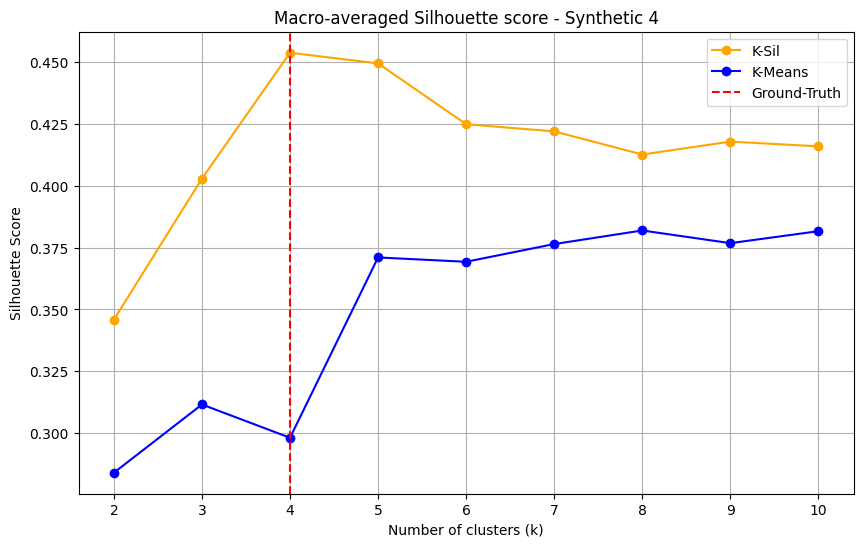

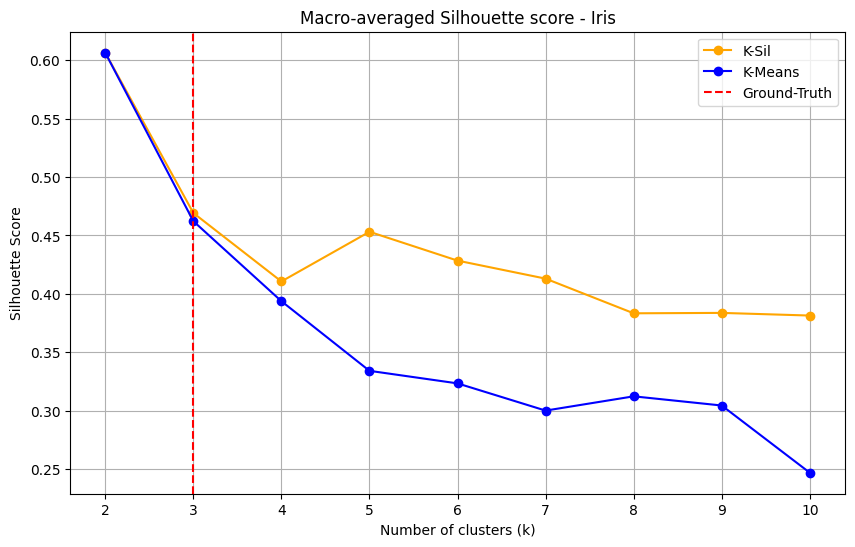

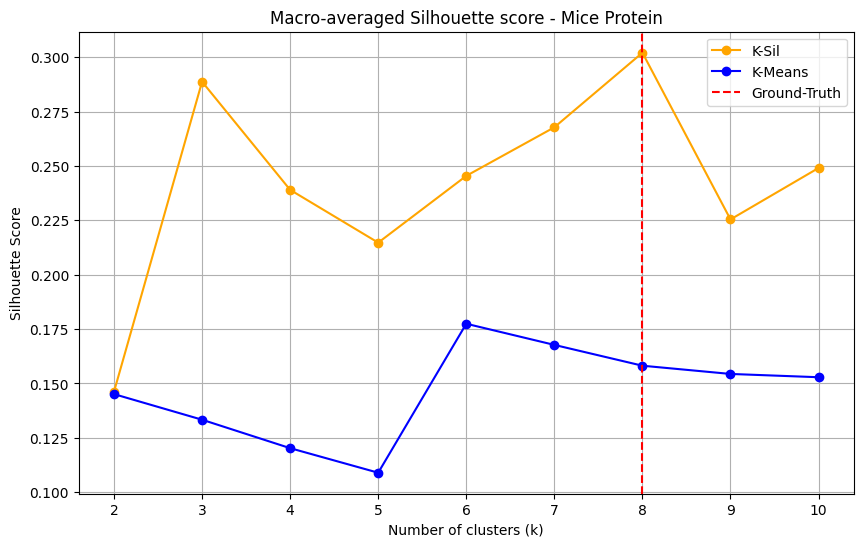

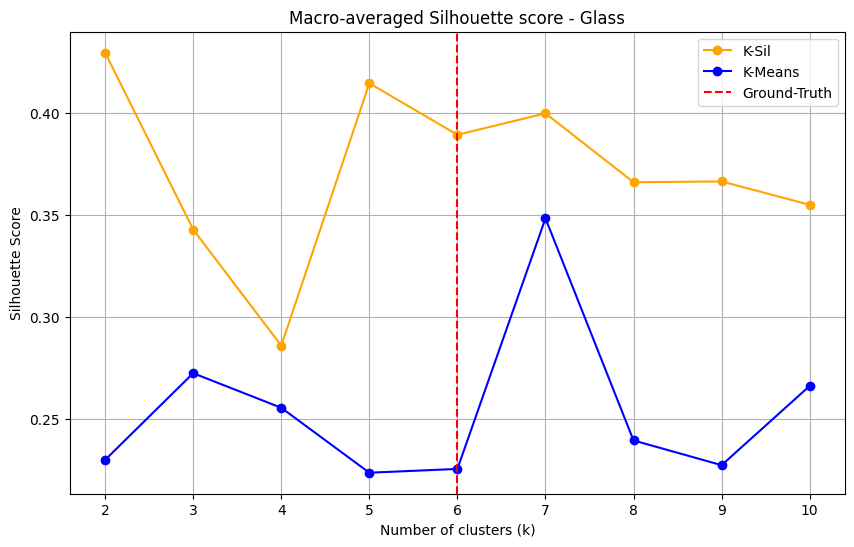

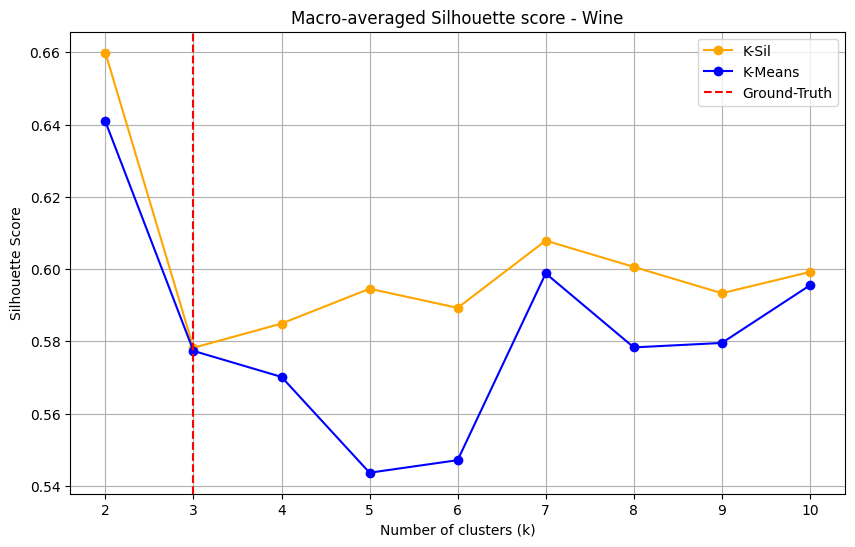

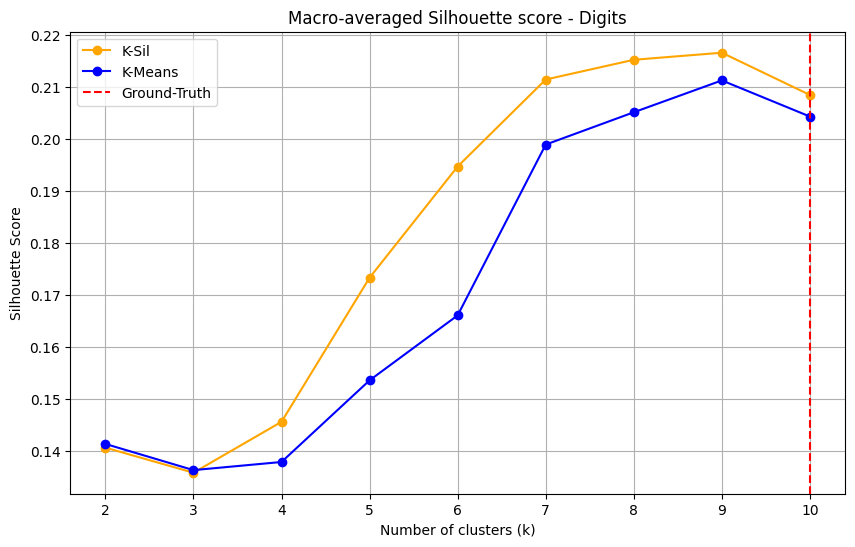

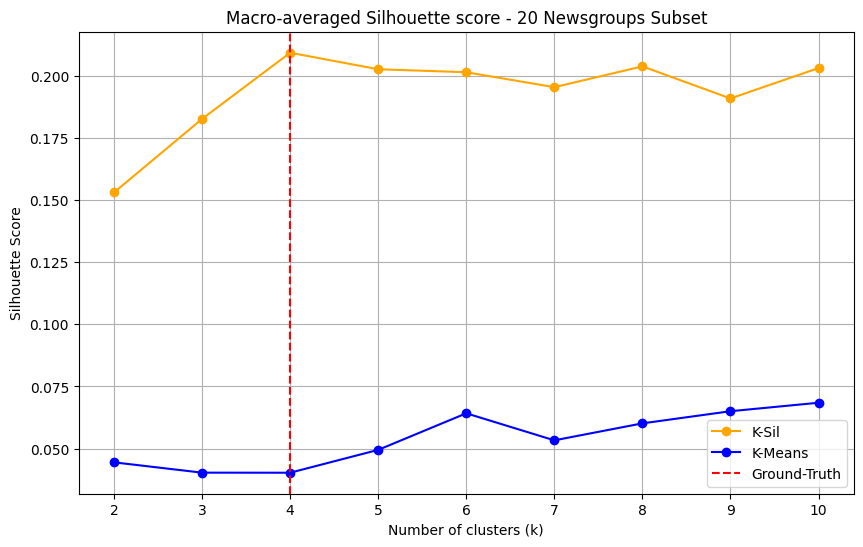

In [7]:
datasets_info = [
    (X_vb, 5, "Synthetic 1", -1),
    (X_high_dim_1, 5, "Synthetic 2", -1),
    (X_high_dim_2, 5, "Synthetic 3", -1),
    (X_challenging, 4, "Synthetic 4", 0.8),
    (X_iris_scaled, 3, "Iris", -1),
    (X_mice_scaled, 8, "Mice Protein", -1),
    (X_glass_scaled, 6, "Glass", -1),
    (X_wine_reduced, 3, "Wine", -1),
    (X_digits_reduced, 10, "Digits", -1),
    (X_tfidf_o, 4, "20 Newsgroups Subset", -1)
]

k_range = range(2, 11)

for X, groundtruth, ds_name, sampling in datasets_info:

    silhouette_scores_ksil = []
    silhouette_scores_kmeans = []

    for k in k_range:
        best_score = -float('inf')
        for approximation in [True, False]:
            for scheme in ["power", "exponential"]:
                ksil = KSil(n_clusters=k,
                            random_state=42,
                            silhouette_objective='macro',
                            init_method='random',
                            weighting=scheme,
                            sensitivity='auto',
                            approximation=approximation,
                            sample_size=sampling).fit(X)
                score = Silhouette.Macro(X, ksil.labels_)
                if score > best_score:
                    best_score = score
        silhouette_scores_ksil.append(best_score)

        kmeans = KMeans(n_clusters=k, random_state=42, init='random', n_init=1)
        labels_kmeans = kmeans.fit_predict(X)
        score_kmeans = Silhouette.Macro(X, labels_kmeans)
        silhouette_scores_kmeans.append(score_kmeans)

    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range), silhouette_scores_ksil, marker='o', color='orange', label='K-Sil')
    plt.plot(list(k_range), silhouette_scores_kmeans, marker='o', color='blue', label='K-Means')
    plt.axvline(x=groundtruth, color='red', linestyle='--', label='Ground-Truth')
    plt.title(f"Macro-averaged Silhouette score - {ds_name}")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    plt.show()
